参考：https://github.com/graykode/nlp-tutorial/tree/master
# 环境

windows 11

Python 3.11.14 

包环境：
- numpy 1.23.5
- torch 2.2.2
- matplotlib 3.7.0

也没有这么严格的要求，能不冲突就行

# 导入一些包
首先要先导入一些常用的库

In [41]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

解决可能会有的老环境问题

In [42]:
import numpy as np

在 Transformer 中主要用于处理矩阵运算、生成位置编码（Positional Encoding）的三角函数序列，以及处理一些数组形状的变换。

In [43]:
import torch

这个是PyTorch 的核心库，提供了张量操作，支持GPU加速

In [44]:
import torch.nn as nn

PyTorch 的神经网络模块（neural network）

In [45]:
import torch.optim as optim

提供一些优化器，包含了如 Adam、SGD 等优化器，用于根据损失函数计算的梯度来更新模型参数。

In [46]:
import matplotlib.pyplot as plt

画图用的

# 数据集

因为是演示，所以简单提供一些数据就行。写的简陋些，就假设要训练一个德语翻译为英语的任务：ich mochte ein bier P翻译为i want a beer

代码里准备了三份数据：

enc_inputs: ich mochte ein bier P (Encoder 看到的原话)

dec_inputs: S i want a beer (Decoder 看到的“辅助信息”，告诉它：从 S 开始，后面跟着这些词)

target： i want a beer E (模型真正的“学习目标”，告诉它：最后要输出这些词，并以 E 结束)

这种机制在深度学习中被称为 Teacher Forcing（老师引导/强制教学）。dec_inputs和target有点像，因为dec_inputs是输入，用于给模型参考的。而target是目标，是标准答案。它们的关系是错开一位的：



| 时间步 (Step) | Decoder 输入 (dec_inputs) | 模型尝试预测的词 | 标准答案 (target_batch) |
| ------------- | ------------------------- | ---------------- | ----------------------- |
| 第 1 步       | **S**                     | $\rightarrow$    | **i**                   |
| 第 2 步       | S **i**                   | $\rightarrow$    | **want**                |
| 第 3 步       | S i **want**              | $\rightarrow$    | **a**                   |
| 第 4 步       | S i want **a**            | $\rightarrow$    | **beer**                |
| 第 5 步       | S i want a **beer**       | $\rightarrow$    | **E**                   |

`dec_inputs` 总是比 `target` 早一个位置（这也是论文中的Transformer框架图里面为什么还注上了Shift Right）。模型在每个位置的任务都是：根据已经看到的词，预测下一个词。

这个是训练部分，当然在真实的测试场景根本没有target，因为还不知道答案。

In [47]:
sentences = ['ich mochte ein bier P', 'S i want a beer', 'i want a beer E']

# 词表与Target/Source长度

## 词表
那么除了提供训练的句子，还要有一个词表用于分词，所以自己定义了一个词表:

这个是source的词表：`src_vocab = {'P': 0, 'ich': 1, 'mochte': 2, 'ein': 3, 'bier': 4}`

这个是Target的词表：`tgt_vocab = {'P': 0, 'i': 1, 'want': 2, 'a': 3, 'beer': 4, 'S': 5, 'E': 6}`

`tgt_vocab`比`src_vocab`多了 'S' 和 'E'。并且`src_vocab`有一个‘P’.因为`src_vocab`是给Encoder用的（德语），而`tgt_vocab`是给Decoder用的（英语）。

这些都是特殊字符：

`S` (Start / BOS - Beginning of Sentence)，他是解码器的起始符号。在推理（翻译）时，解码器（Decoder）第一步并不知道该输出什么。我们会喂给它一个 `S`，告诉它从这里开始翻译第一个词。

`E` (End / EOS - End of Sentence)，是句子的终止符号。训练时，当翻译完最后一个词后，模型要输出一个 `E`表示结束了。这样在实际使用时，看到模型输出了 `E`，就知道翻译结束了，否则它可能会无限循环下去。

`P` (Padding)，就是一个填充符号。用于对齐。如果一个 Batch里，第一句有 5 个词，第二句只有 4 个词，我们会给第二句补上一个 `P`，让两句话长度一致，方便并行计算。具体来说，Padding 的目标是让整个 Batch 变成一个 矩形矩阵（$Batch\_Size \times Seq\_Len$）。这里‘p’是0是有原因的，如果位置向量是全 0，那么根据公式：$$\text{Embedding}(P) + \text{Positional}(0) = \text{Embedding}(P)$$
这意味着填充位 'P' 在空间中没有任何位置偏移，它不会携带任何顺序信息。

还有一个好处是掩码的时候算的很快，因为判断一个数是否等于 0 是最快的。之后代码中的`get_attn_pad_mask`函数会有用到。

**这里说的“词”都是指Token，而不是字符数或单词数，当然真实情况下分词器不一定就是恰好一个单词一个单词分，是按照每个字母组合的概率来分，分出来的有点像是词根词缀**

In [48]:
# Transformer Parameters
# Padding Should be Zero
src_vocab = {'P': 0, 'ich': 1, 'mochte': 2, 'ein': 3, 'bier': 4}
src_vocab_size = len(src_vocab)

tgt_vocab = {'P': 0, 'i': 1, 'want': 2, 'a': 3, 'beer': 4, 'S': 5, 'E': 6}
number_dict = {i: w for i, w in enumerate(tgt_vocab)} # 做一个反向的映射数字->单词
tgt_vocab_size = len(tgt_vocab)

`number_dict`用于解码，把模型输出的数字，翻译回人能看的单词。

比如： \[1, 2, 3, 4, 6] → i want a beer E

## Target/Source长度

In [49]:
src_len = 5 # length of source
tgt_len = 5 # length of target

还要设置source和target的长度，这里统一设置为5

比如传进去的`batch_size`参数设为2，那么比如有这样的句子：

Gib mir ein Glas Wasser

ich mochte ein bier

规定按照单词来分词的话，那么显然第一句和第二句的长度不一样，第二句少了一个Token，要补一个P，这样让两句话长度一致，方便并行计算。所以这也是为什么我给的句子中是“ich mochte ein bier P”而不是“ich mochte ein bier”

在实际的大规模模型（如 GPT 或 BERT）中，一般会使用专门的 Tokenizer（如 Byte-Pair Encoding, BPE）。但在这段代码里，我使用的是最原始的空格切分：`input_batch = [[src_vocab[n] for n in sentences[0].split()]]`。

在时间序列任务中，为了让 Decoder 更有序地预测，通常会给它一段已知的历史数据作为前缀（即https://github.com/thuml/Time-Series-Library 启动脚本中的label_len部分），这和 NLP 的 Teacher Forcing 非常像。

| 时间序列参数 | 含义                                      | 对应你代码中的部分                       |
| ------------ | ----------------------------------------- | ---------------------------------------- |
| `seq_len`    | 历史观察窗口长度 (Look-back window)       | `src_len` (Encoder 输入的长度，这里是 5) |
| `label_len`  | Decoder 能看到的“已知答案”长度 (作为提示) | `dec_inputs` 中的 `S` 及其后续部分       |
| `pred_len`   | 最终要预测的未来长度                      | `target` 中除去前缀后的部分              |

分完词后，要转换为数字，这也叫Numericalization（数值化），把这些Token映射成词表里的索引数字。例如ich变成1。所以要写一个函数负责数值化，这里起名为`make_batch`（见后续的代码实现）,然后还要对其进行向量化（Embedding）将数字索引变成浮点数向量比如\[0.12, -0.55... \]之类的。pytorch提供了一个方法，在模型里我用nn.Embedding负责向量化。

这样就完成了框架图中的Embedding部分：

<img src="./注意力机制/ModalNet-21.png" width="400" style="display: block; margin: 0 auto;">

# 超参数设置：

In [50]:
d_model = 512  # Embedding Size
d_ff = 2048  # FeedForward dimension
d_k = d_v = 64  # dimension of K(=Q), V
n_layers = 6  # number of Encoder of Decoder Layer
n_heads = 8  # number of heads in Multi-Head Attention

| 参数名            | 大小 | 深度说明                                                     |
| ----------------- | ---- | ------------------------------------------------------------ |
| `d_model`         | 512  | 模型维度。它是 Embedding 的长度，也是残差连接（Residual）路径上向量的长度。 |
| `d_ff`            | 2048 | 前馈网络中间层维度。在 FFN 中，向量会先从 512 升维到 2048，再降回 512。 |
| `d_k = d_q = d_v` | 64   | 单头维度。每个注意力头在计算时，会将 512 维“切开”进入 64 维的子空间进行观察。 |
| `n_layers`        | 6    | 堆叠层数。论文中 Encoder 和 Decoder 分别由 6 个完全相同的层堆叠而成（即 $N=6$）。 |
| `n_heads`         | 8    | 头数**。决定了模型同时在多少个不同的语义子空间中进行并行注意力计算。 |

# 模型代码

## 多头注意力机制

这个部分实现了注意力公式：$$\text{Attention}(Q, K, V) = \text{Softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$


In [51]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()

    def forward(self, Q, K, V, attn_mask):
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k) # scores : [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        scores.masked_fill_(attn_mask, -1e9) # Fills elements of self tensor with value where mask is one.
        attn = nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn, V)
        return context, attn

- torch.matmul：这个是pytorch的批量矩阵乘法，它会保持前两个维度（batch 和 n_heads）不动，只对最后两个维度执行矩阵乘法。计算的形状变化：$$[batch, n\_heads, len\_q, d\_k] \times [batch, n\_heads, d\_k, len\_k] = [batch, n\_heads, len\_q, len\_k]$$表示的意义是对于每一个头，查询句中的每一个词（len_q）对键句中的每一个词（len_k）的关注程度。当然如果是二维矩阵直接用`.T`也是可以的，对于这种 4 维张量，只想交换最后两个维度还是直接用transpose会更好些
- masked_fill_：直接原地修改`scores`这个变量，将所有之前算出来的attn_mask中维True的位置全部换成一个很小的数字，这样在做softmax之后，$e^{-1e9}$就约等于0
- context是$\vec{E}_n + \Delta \vec{E}_n = \vec{E}'_n$中$\Delta \vec{E}_n$的一部分，是每一个头产生的增量。

此外关于为什么对最后一个维度做Softmax，是因为公式中是$Q K^T$，所以得到的矩阵行是Q，列是K的相关信息，逐列做归一化，就是在计算每个Token的Q对于句子中每一个Token产生的K的注意力分数的归一化。以那一句德语为例，这句德语：\['ich', 'mochte', 'ein', 'bier', 'P']由于参数是`batch_size = 1, n_heads = 8, d_model = 512, d_k = 64`。可以得到矩阵的整体形状是[1, 8, 5, 5]。为了直观，只看其中一个 Head，它的横轴（列）是 Key，纵轴（行）是 Query，可能得注意力分数是：
| Query \ Key | ich (1) | mochte (2) | ein (3) | bier (4) | P (0) | 行总和 |
| ----------- | ------- | ---------- | ------- | -------- | ----- | ------ |
| ich         | 0.8     | 0.1        | 0.05    | 0.05     | 0.0   | 1.0    |
| mochte      | 0.2     | 0.6        | 0.1     | 0.1      | 0.0   | 1.0    |
| ein         | 0.05    | 0.1        | 0.7     | 0.15     | 0.0   | 1.0    |
| bier        | 0.05    | 0.1        | 0.25    | 0.6      | 0.0   | 1.0    |
| P           | 0.2     | 0.2        | 0.2     | 0.2      | 0.2   | 1.0    |


Softmax 的公式是 $P_i = \frac{e^{x_i}}{\sum e^{x_j}}$,所以最后一行就算全是-1e9那么平均下来每个也能分到0.2。这个注意力分数会影响结果，所以我会在最后计算 Loss 的时候，直接设置ignore_index=0，这样计算 Loss 的时候，在PyTorch 检查 target_batch时，凡是标签值为 0（即字符 'P'）的位置，产生的损失都会被直接标记为 0，直接把 P 这个位置产生的任何输出结果给物理抹除。


框架中对应的MultiHeadAttention部分：

In [52]:
class MultiHeadAttention(nn.Module):
    def __init__(self):
        super(MultiHeadAttention, self).__init__()
        self.W_Q = nn.Linear(d_model, d_k * n_heads)
        self.W_K = nn.Linear(d_model, d_k * n_heads)
        self.W_V = nn.Linear(d_model, d_v * n_heads)
        self.linear = nn.Linear(n_heads * d_v, d_model)
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, Q, K, V, attn_mask):
        # q: [batch_size x len_q x d_model], k: [batch_size x len_k x d_model], v: [batch_size x len_k x d_model]
        residual, batch_size = Q, Q.size(0)
        # (B, S, D) -proj-> (B, S, D) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        q_s = self.W_Q(Q).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # q_s: [batch_size x n_heads x len_q x d_k]
        k_s = self.W_K(K).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # k_s: [batch_size x n_heads x len_k x d_k]
        v_s = self.W_V(V).view(batch_size, -1, n_heads, d_v).transpose(1,2)  # v_s: [batch_size x n_heads x len_k x d_v]

        attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1) # attn_mask : [batch_size x n_heads x len_q x len_k]

        # context: [batch_size x n_heads x len_q x d_v], attn: [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        context, attn = ScaledDotProductAttention()(q_s, k_s, v_s, attn_mask)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_heads * d_v) # context: [batch_size x len_q x n_heads * d_v]
        output = self.linear(context)
        return self.layer_norm(output + residual), attn # output: [batch_size x len_q x d_model]

这个模型在初始化的时候的参数，对应了GPT-3的Query，Key，Value，Output：
<img src="./注意力机制/image-1.png" width="700" style="display: block; margin: 0 auto;">

| 变量          | 对应的层 | GPT-3 的参数计算公式                                        |
| ------------- | -------- | ----------------------------------------------------------- |
| `self.W_Q`    | Query    | $d\_query \times d\_embed \times n\_heads \times n\_layers$ |
| `self.W_K`    | Key      | $d\_query \times d\_embed \times n\_heads \times n\_layers$ |
| `self.W_V`    | Value    | $d\_value \times d\_embed \times n\_heads \times n\_layers$ |
| `self.linear` | Output   | $d\_embed \times d\_value \times n\_heads \times n\_layers$ |

而代码中的`self.layer_norm = nn.LayerNorm(d_model)`则是层归一化层，当然他的维度是和词向量大小`d_model`相关。代码里 n_layers = 6，所以总参数量就是这些线性层参数之和再乘以 6。

q_s、k_s、v_s是对 $Q, K, V$ 做了完全相同的变换，以$Q$为例,
- 第一步是线性投影，对应代码中的`self.W_Q(Q)`,表示将原始词向量通过矩阵乘法，投影到一个新的特征空间，即$Q_{proj} = Q \cdot W^Q$。
- 第二步是维度拆分，对应代码中`.view(batch_size, -1, n_heads, d_k)`表示将原本 $512$ 维的向量，“切”成了 $8$ 个 $64$ 维的小向量。这是多头的物理实现。
- 第三步是对维度的转置，对应代码中`.transpose(1, 2)`表示从从 [batch, len, 8, 64] 变成 [batch, 8, len, 64]。这是为了后续的矩阵乘法运算，在刚才的`ScaledDotProductAttention`中也可以看到是对最后两个维度做运算。

而`attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1)`表示把之前做好的单层掩码，克隆成一套多头的掩码矩阵，以便它能准确覆盖到每一个注意力头上。
- unsqueeze(1)表示在第 1 维（索引从 0 开始）插入一个长度为 1 的新维度。形状变化：[batch_size, len_q, len_k] $\rightarrow$ [batch_size, 1, len_q, len_k]。目的是为注意力头的腾出位置，即在 batch 和序列长度之间插了一个空位。
- repeat(1, n_heads, 1, 1)表示在第 1 维拷贝 n_heads 次，其余维不变。形状变化：[batch_size, 1, len_q, len_k] $\rightarrow$ [batch_size, 8, 5, 5]（n_head设置为 8 个头）

然后在`context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_heads * d_v)`将 8 个头独立算出的增量重新缝合成一个完整的、与输入维度一致的长向量。

- `transpose(1, 2)`是在把注意力头换回来，因为计算完注意力后，context 的形状是 [batch_size, n_heads, len_q, d_v]（[1, 8, 5, 64]）。这相当于交换第 1 维（n_heads）和第 2 维（len_q），最后会变成[1, 5, 8, 64]。表示重新以单词序列为主序。现在每个单词后面紧跟着 8 个头为它捕捉到的特征信息。
- `contiguous()`是在整理内存，在内存中开辟一块新空间，按照现在的逻辑顺序把数据重新排好。如果不加这一步，下一步的`view`操作会因为内存不连续而报错。
- `view(batch_size, -1, n_heads * d_v)`是在缝合维度，把最后两个维度（8 个头 和 每个头的 64 维）合并成一个维度（$8 \times 64 = 512$）。最终形状：[batch_size, len_q, d_model] (即 [1, 5, 512])。

## 前馈神经网络

Feed Forward部分

In [53]:
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self):
        super(PoswiseFeedForwardNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, inputs):
        residual = inputs # inputs : [batch_size, len_q, d_model]
        output = nn.ReLU()(self.conv1(inputs.transpose(1, 2)))
        output = self.conv2(output).transpose(1, 2)
        return self.layer_norm(output + residual)

这一部分也叫多层感知机。

<img src="./注意力机制/image-2.png" width="700" style="display: block; margin: 0 auto;">

在init中：
- `self.conv1` 表示将 d_model (512) 映射到 d_ff (2048)。即特征放大，寻找更细微的模式。对应图中第一个线性层
- `self.conv2`表示将 d_ff (2048) 压缩回 d_model (512)。用于还原原始的词向量
- `self.layer_norm`层归一化，这图中没有标明，实际位置在$\oplus$ 之后，这个实际上是在将得到的新词向量做一个归一化，虽然在进入 `PoswiseFeedForwardNet` 时，多头的 `context` 早就已经被缝合成一个统一的向量了,主要是为了防止向量里的数值在经过 $512 \rightarrow 2048 \rightarrow 512$ 的剧烈变换后变得忽大忽小。确保下一层（比如另一个 Encoder 层）接收到的输入是标准的，不会导致梯度爆炸。


对应了这个GPT-3图中的up-projection和down-projection：

<img src="./注意力机制/image-1.png" width="700" style="display: block; margin: 0 auto;">



## Encoder相关

In [54]:
def get_attn_pad_mask(seq_q, seq_k):
    # 比如在Encoder的调用里面，都是 enc_inputs: [[1, 2, 3, 4, 0]]
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # eq(0) 是判断哪些位置等于 0 (即 P)
    # pad_attn_mask 变成: [[False, False, False, False, True]]
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)  # batch_size x 1 x len_k(=len_q), one is masking
    # expand 扩展成矩阵: [1, 5, 5]
    return pad_attn_mask.expand(batch_size, len_q, len_k)  # batch_size x len_q x len_k

函数返回的是一个 布尔矩阵（Mask 矩阵）。对于 ich mochte ein bier P 这句话，它生成的 Mask 矩阵看起来像这样（用 1 代表 True/屏蔽）：

|        | ich  | mochte | ein  | bier | P    |
| ------ | ---- | ------ | ---- | ---- | ---- |
| ich    | 0    | 0      | 0    | 0    | 1    |
| mochte | 0    | 0      | 0    | 0    | 1    |
| ...    | 0    | 0      | 0    | 0    | 1    |
| P      | 0    | 0      | 0    | 0    | 1    |

表示无论这个Token是谁（每一行代表一个词），当这个Token回头看全句时，最后一列的 P 都要被抹掉。

In [55]:
def get_sinusoid_encoding_table(n_position, d_model):
    # 算角度
    def cal_angle(position, hid_idx):
        return position / np.power(10000, 2 * (hid_idx // 2) / d_model)
    # 算向量
    def get_posi_angle_vec(position):
        return [cal_angle(position, hid_j) for hid_j in range(d_model)]
    # 先求出公式中括号里面的
    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(n_position)])
    # 分给sin和cos 
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1
    return torch.FloatTensor(sinusoid_table)

代码中的逻辑其实是在实现论文里的这两个公式：
$$PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$

$$PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$

关于为什么要用这种奇怪的 $\sin$ 和 $\cos$，主要是这三个原因。

第一个是有界性的考虑。$\sin$ 和 $\cos$ 的值永远在 $[-1, 1]$ 之间。如果直接用 $1, 2, 3...$，当句子很长时，位置值会变得巨大，干扰词向量的特征。

第二个是相对位置关系方便表示，根据三角函数公式：

$$\sin(\alpha + \beta) = \sin\alpha\cos\beta + \cos\alpha\sin\beta$$

这说明对于任何固定的偏移 $k$，$PE_{pos+k}$ 都可以表示为 $PE_{pos}$ 的线性组合。这让模型能够非常容易地学习到词与词之间的相对距离。

第三就是唯一性。由于每一维的频率（分母里的 $10000^{...}$）都不同，从第 0 维到第 511 维，波长是逐渐拉长的。这保证了每一个位置生成的 512 维向量都是唯一的。

In [56]:
class EncoderLayer(nn.Module):
    def __init__(self):
        super(EncoderLayer, self).__init__() # 初始化父类，确保能够使用nn.Module中的自动追踪权重、支持移动到GPU等
        self.enc_self_attn = MultiHeadAttention() # 多头注意力
        self.pos_ffn = PoswiseFeedForwardNet() # 前馈神经层

    def forward(self, enc_inputs, enc_self_attn_mask):
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # 去做自注意力，Q,K,V都是enc_inputs
        enc_outputs = self.pos_ffn(enc_outputs) # enc_outputs: [batch_size x len_q x d_model]
        return enc_outputs, attn

enc_outputs是经过多头注意力（Multi-Head Attention）和前馈网络（FFN）处理后的新向量。

- 进去前向量只代表词本身（比如 bier 只代表啤酒）。
- 出来后向量融入了周围词的信息（比如 bier 的向量现在包含了“它是 ich 想要的那个 bier”这种语境信息）。

这个 enc_outputs 会作为下一层 Encoder Layer 的输入继续被精炼。层数给了 6 层，相当于被精炼 6 次。

attn是注意力权重矩阵（打分表）就是产生了注意力分数的矩阵。

In [57]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.src_emb = nn.Embedding(src_vocab_size, d_model) #Token的Embedding
        self.pos_emb = nn.Embedding.from_pretrained(get_sinusoid_encoding_table(src_len+1, d_model),freeze=True) #位置编码
        self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)]) #产生n_layers个层

    def forward(self, enc_inputs): # enc_inputs : [batch_size x source_len]
        enc_outputs = self.src_emb(enc_inputs) + self.pos_emb(torch.LongTensor([[1,2,3,4,0]])) #特征融合，整合词义信息和位置信息
        enc_self_attn_mask = get_attn_pad_mask(enc_inputs, enc_inputs) # 在计算注意力时，忽略为了凑长度而补进去的 P（Padding）。
        enc_self_attns = [] #存每一层的注意力分数表，可视化会用到
        for layer in self.layers:
            enc_outputs, enc_self_attn = layer(enc_outputs, enc_self_attn_mask)
            enc_self_attns.append(enc_self_attn)
        return enc_outputs, enc_self_attns

- nn.Embedding：nn.Embedding就是一个模型能够理解的字典。第一维是词表大小，是整个字典里有多少个不重复的词，因为是Encoder层，所以词表大小是src_vocab_size。d_model是每一个 Token 被转化成的向量维度（这里是 512）。当然，在更高级的 NLP 任务中，经常会加载预训练词向量而不是让模型自己去学（如 Word2Vec 或 GloVe）。
- Embedding.from_pretrained：from_pretrained 是一个特殊的构造方法。它改变了字典的生成方式。普通构造是需要去训练的，构造出来的全是全是随机生成的数字，但是这个方法会给一个已经算好的矩阵（Tensor）让它直接用这些数字作为初始内容。具体的数字源于get_sinusoid_encoding_table 函数，这个函数通过 $sin$ 和 $cos$ 的数学公式，预先计算出了一个形状为 \[6, 512] 的矩阵。这里多加了一维，为了兼容Decoder中的‘S’。
- 特征融合这里，self.pos_emb(torch.LongTensor(\[\[1,2,3,4,0]]))这个顺序是和输入的句子意义对应的：'ich mochte ein bier P'。当然这是为了演示，真实情况肯定不是这样硬编码的
- for循环是在精炼语义，可能得情况是第 1 层理解基础语法，比如主谓关系。到第 6 层就能够理解高级语义，即词语在句子里的最终含义。最后返回的 enc_outputs就是 Encoder 对这句德语的最终理解结果。它会被送往 Decoder，作为翻译的参考。

这样就完成了模型框架中的词嵌入以及编码层。
<img src="./注意力机制/image-3.png" width="400" style="display: block; margin: 0 auto;">

## Dncoder相关

`get_attn_subsequent_mask`是和Masked Multi-Head Attention相关，Encoder 的 Mask 只是为了挡住 P (Padding)，而这个方法生成的是上三角矩阵。

In [58]:
def get_attn_subsequent_mask(seq):
    attn_shape = [seq.size(0), seq.size(1), seq.size(1)]
    subsequent_mask = np.triu(np.ones(attn_shape), k=1)
    subsequent_mask = torch.from_numpy(subsequent_mask).byte()
    return subsequent_mask

In [59]:
# 测试，模拟一个 Batch_size=1, 长度为 5 的序列
test_seq = torch.LongTensor([[1, 2, 3, 4, 5]])
mask = get_attn_subsequent_mask(test_seq)

print("Generated Subsequent Mask (1 means MASKED):")
print(mask[0].numpy())

Generated Subsequent Mask (1 means MASKED):
[[0 1 1 1 1]
 [0 0 1 1 1]
 [0 0 0 1 1]
 [0 0 0 0 1]
 [0 0 0 0 0]]


[[0 1 1 1 1]  第一行：只能看索引0，不能看1,2,3,4
 
 [0 0 1 1 1]  第二行：只能看索引0,1，不能看2,3,4
 
 [0 0 0 1 1]  第三行：只能看索引0,1,2，不能看3,4
 
 [0 0 0 0 1]  第四行：只能看索引0,1,2,3，不能看4
 
 [0 0 0 0 0]] 第五行：全都能看

In [60]:
class DecoderLayer(nn.Module):
    def __init__(self):
        super(DecoderLayer, self).__init__()
        self.dec_self_attn = MultiHeadAttention()
        self.dec_enc_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, dec_inputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask):
        dec_outputs, dec_self_attn = self.dec_self_attn(dec_inputs, dec_inputs, dec_inputs, dec_self_attn_mask)
        dec_outputs, dec_enc_attn = self.dec_enc_attn(dec_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)
        dec_outputs = self.pos_ffn(dec_outputs)
        return dec_outputs, dec_self_attn, dec_enc_attn

- `self.dec_self_attn`：这个是先做了一个自我回顾，$Q, K, V$ 全部来自 `dec_inputs`（即目标语言序列 "S I want a beer"）。并且使用的是`dec_self_attn_mask`这个上三角矩阵。这是在让模型在产生当前单词时，能够参考已经生成出来的单词。因为有了上三角掩码，模型在这一步只能看到历史信息，不能偷看后面的结果。
- `self.dec_enc_attn`：这一步是在做交叉注意力，上一步产生的`dec_outputs`作为$Q$ (Query)，`enc_outputs`作为$K$ (Key) 和 $V$ (Value)，代表通过Encoder后原文（德语）的所有特征信息。注意这里的`dec_enc_attn_mask`掩码只负责遮住原文里的 P (Padding)，不需要遮住未来，因为之后的句子本身就看不到。这里就是真的在做翻译了，模型拿着已经翻译出的英语单词作为搜索词，去德语原文里寻找最相关的词（比如翻译 "beer" 时，它会去原文里定位到 "bier"）。
- `self.pos_ffn`：这个是做了一个全连接，将整合的结果进入到前馈神经网络（MLP）来对融合后的特征进行非线性映射和进一步升维提取

Encoder层和Decoder层对比：

| 特性   | EncoderLayer           | DecoderLayer                                        |
| ------ | ---------------------- | --------------------------------------------------- |
| 层数   | 2 层 (Self-Attn + FFN) | 3 层 (Self-Attn + Cross-Attn + FFN)                 |
| 掩码   | 只遮 Padding           | Self-Attn 遮未来的词汇；Cross-Attn 遮原文的 Padding |
| 数据源 | 纯粹的源语言           | 混合源语言（K, V）和目标语言（Q）                   |

In [61]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.tgt_emb = nn.Embedding(tgt_vocab_size, d_model)
        self.pos_emb = nn.Embedding.from_pretrained(get_sinusoid_encoding_table(tgt_len+1, d_model),freeze=True)
        self.layers = nn.ModuleList([DecoderLayer() for _ in range(n_layers)])

    def forward(self, dec_inputs, enc_inputs, enc_outputs): # dec_inputs : [batch_size x target_len]
        dec_outputs = self.tgt_emb(dec_inputs) + self.pos_emb(torch.LongTensor([[5,1,2,3,4]]))
        dec_self_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs)
        dec_self_attn_subsequent_mask = get_attn_subsequent_mask(dec_inputs)
        dec_self_attn_mask = torch.gt((dec_self_attn_pad_mask + dec_self_attn_subsequent_mask), 0)

        dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs)

        dec_self_attns, dec_enc_attns = [], []
        for layer in self.layers:
            dec_outputs, dec_self_attn, dec_enc_attn = layer(dec_outputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask)
            dec_self_attns.append(dec_self_attn)
            dec_enc_attns.append(dec_enc_attn)
        return dec_outputs, dec_self_attns, dec_enc_attns

这个和Encoder类很像，它把多个 DecoderLayer 堆叠起来，并初始化目标词向量。
- `torch.gt`：gt 是 "Greater Than" 的缩写，先将两张矩阵相加,相加后，只要某个位置原本在任意一张矩阵里是 1，加完后的值就会是 1 或 2,也就大于0，并将其转换为布尔值。大于0的是True，小于0是False。这样就能整合pad的掩码以及遮掉上三角矩阵的掩码，这就保证了模型在自注意力阶段既不会看 P，也不会看未来的词。
- `dec_enc_attn_mask`：遮住的是 `enc_inputs` 里的 P，为了 `DecoderLayer` 里的第二层注意力准备的。
- for循环同样是在精炼语义，最后整合Dcoder 对这句德语的最终理解结果。

# Transformer主类

In [62]:
class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        # 最后的线性投影层：将向量打回词表大小
        self.projection = nn.Linear(d_model, tgt_vocab_size, bias=False)

    def forward(self, enc_inputs, dec_inputs):
        # 第一步：原文进，输出特征
        enc_outputs, enc_self_attns = self.encoder(enc_inputs)
        # 第二步：译文前缀+原文特征进入，生成特征
        dec_outputs, dec_self_attns, dec_enc_attns = self.decoder(dec_inputs, enc_inputs, enc_outputs)
        # 第三步：将 [batch, len, 512] 映射为 [batch, len, 7]
        dec_logits = self.projection(dec_outputs) # dec_logits : [batch_size x src_vocab_size x tgt_vocab_size]
        # 第四步：变形为 [batch*len, 7] 方便计算交叉熵损失，view是在缝合前两个维度
        return dec_logits.view(-1, dec_logits.size(-1)), enc_self_attns, dec_self_attns, dec_enc_attns

# 画图函数

In [73]:
def showgraph(attn,name):
    # 传入一个注意力矩阵，当然一个三个维度，第一个维度表示是哪一个注意力头，这里选取 [-1] 代表取最后一层的输出，因为最后一层的理解通常最深刻。
    attn = attn[-1].squeeze(0)[0] # squeeze(0)：去掉 Batch 维度（即从 [1, 8, 5, 5] 变成 [8, 5, 5]）。并且取了第一个头的注意力分数
    attn = attn.data.numpy()

    fig = plt.figure(figsize=(n_heads, n_heads))
    ax = fig.add_subplot(1, 1, 1)
    im = ax.matshow(attn, cmap='viridis') # 把矩阵里的权重数值（0 到 1 之间）映射成颜色（紫色到黄色）。颜色越亮（趋向黄色），代表注意力权重越高。

    ax.set_xticks(range(len(sentences[0].split())))
    ax.set_yticks(range(len(sentences[2].split())))
    # 坐标轴的数字索引换成真正的单词
    ax.set_xticklabels(sentences[0].split(), rotation=90)
    ax.set_yticklabels(sentences[2].split())

    plt.colorbar(im)
    plt.savefig(name+'attention.png')
    plt.show()

# 模型训练与结果可视化

随机种子函数

In [64]:
def set_seed(seed=2026):
    import random
    random.seed(seed)                          # 1. 锁定 Python 原生随机数
    np.random.seed(seed)                       # 2. 锁定 NumPy 随机数
    torch.manual_seed(seed)                    # 3. 锁定 CPU 上的 PyTorch
    torch.cuda.manual_seed(seed)               # 4. 锁定 GPU 上的 PyTorch
    torch.cuda.manual_seed_all(seed)           # 5. 如果使用多块 GPU，全锁定
    # 6. 确定性运算（会稍微降低一点点训练速度，但能保证结果一模一样）
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(2026) # 调用函数，设置一个数字

In [65]:
model = Transformer()

初始化模型

In [66]:
def make_batch(sentences):
    input_batch = [[src_vocab[n] for n in sentences[0].split()]]
    output_batch = [[tgt_vocab[n] for n in sentences[1].split()]]
    target_batch = [[tgt_vocab[n] for n in sentences[2].split()]]
    return torch.LongTensor(input_batch), torch.LongTensor(output_batch), torch.LongTensor(target_batch)

在这之前要先讲sentences进行数值化

In [67]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=0.0001) # 调小一点
enc_inputs, dec_inputs, target_batch = make_batch(sentences) # 数值化原始句子
enc_inputs, dec_inputs, target_batch

(tensor([[1, 2, 3, 4, 0]]),
 tensor([[5, 1, 2, 3, 4]]),
 tensor([[1, 2, 3, 4, 6]]))

交叉熵作为损失函数，Adam作为优化器

In [68]:
for epoch in range(100):  # 把上限设高一点，交给早停来控制
    optimizer.zero_grad()
    outputs, enc_self_attns, dec_self_attns, dec_enc_attns = model(enc_inputs, dec_inputs)
    loss = criterion(outputs, target_batch.contiguous().view(-1))
    
    # 打印进度
    if (epoch + 1) % 10 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

    # --- 早停 ---
    if loss < 0.0001:
        print('已达到预期精度，在第 %d 轮提前停止训练' % (epoch + 1),'cost =', '{:.6f}'.format(loss))
        break

    loss.backward()
    optimizer.step()

Epoch: 0010 cost = 0.001163
Epoch: 0020 cost = 0.000583
Epoch: 0030 cost = 0.000113
已达到预期精度，在第 31 轮提前停止训练 cost = 0.000100


多训练几轮，反正就一句话，设置loss为0.0001就停

ich mochte ein bier P -> ['i', 'want', 'a', 'beer', 'E']
first head of last state enc_self_attns


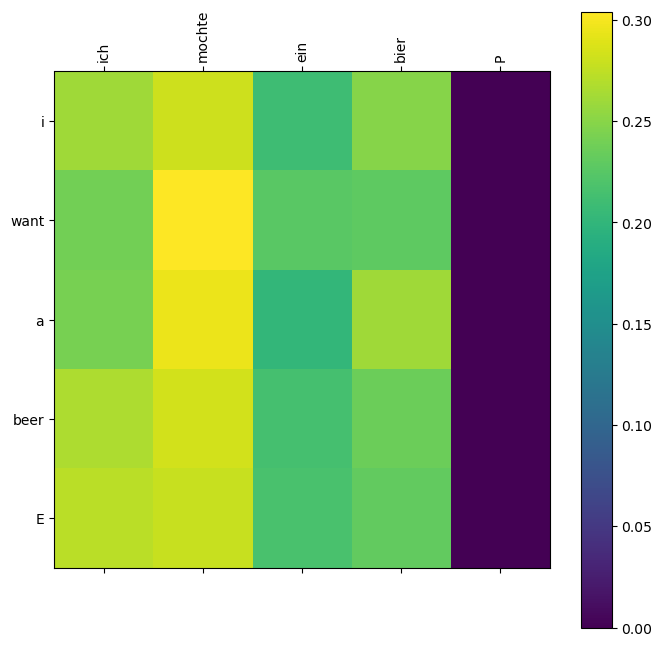

first head of last state dec_self_attns


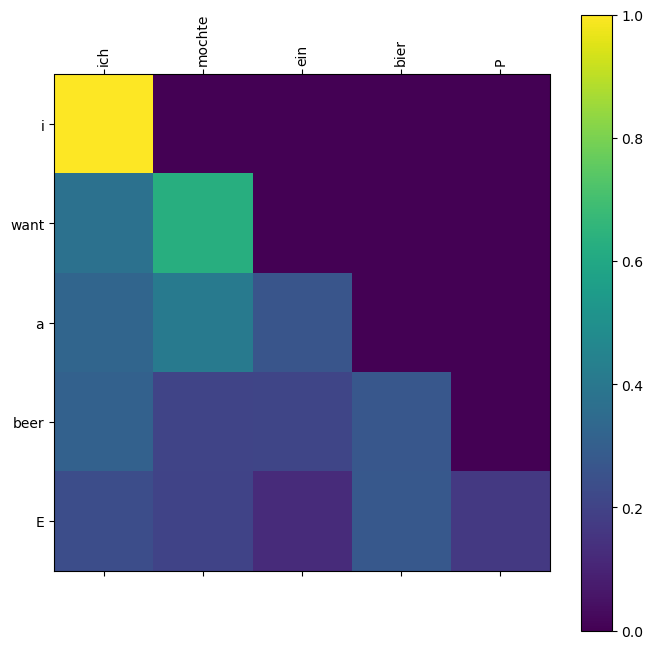

first head of last state dec_enc_attns


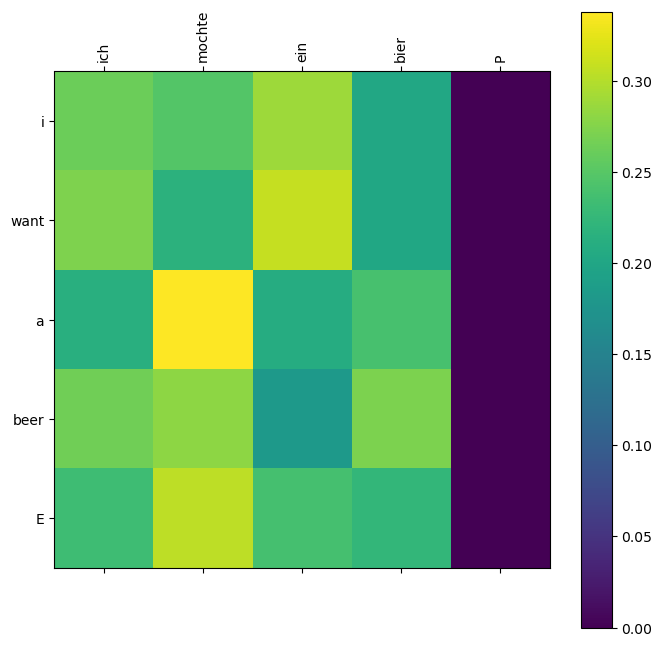

In [74]:
# Test
predict, _, _, _ = model(enc_inputs, dec_inputs)
predict = predict.data.max(1, keepdim=True)[1]
print(sentences[0], '->', [number_dict[n.item()] for n in predict.squeeze()])

print('first head of last state enc_self_attns')
showgraph(enc_self_attns,'enc_self_attns')

print('first head of last state dec_self_attns')
showgraph(dec_self_attns,'dec_self_attns')

print('first head of last state dec_enc_attns')
showgraph(dec_enc_attns,'dec_enc_attns')

第一张图：

<img src="./注意力机制/enc_self_attnsattention.png" width="400" style="display: block; margin: 0 auto;">

Encoder 自注意力图。展示的是德语单词之间的自我关联（自注意）情况。每个词在关注自己的同时，也对整句的其他词有均匀的亮度分布。最后的 P（Padding）列是黑色的，说明 get_attn_pad_mask 成功工作了，模型忽略了无意义的填充符。

第二张图：

<img src="./注意力机制/dec_self_attnsattention.png" width="400" style="display: block; margin: 0 auto;">

Decoder 自注意力图。右上角完全黑暗的部分说明了代码中`get_attn_subsequent_mask`得到的上三角矩阵起作用了。

第三张图：

<img src="./注意力机制/dec_enc_attnsattention.png" width="400" style="display: block; margin: 0 auto;">

Decoder-Encoder 跨注意力图。有对角线对齐趋势，这说明成功地在德语原文中定位到了对应的词汇。